In [1]:
import sys
sys.path.insert(0, '../../')   # для обращения к родительской директории
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# для отрисовки временного ряда с разметкой неисправностей
from notebook.utils import plot_failure

In [2]:
def drop_rows(X, y, df):
    '''Функция для исключения нужных строк из X и y по датам
    df - датафрейм с данными, которые нужно удалить'''

    rows = []
    start_col = df['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ']
    end_col = df['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ']

    for start, end in zip(start_col, end_col):
        indexes = X.loc[(X.index >= start) & (X.index <= end)].index
        rows.extend(indexes)
    
    return X.drop(rows), y.drop(rows)

In [3]:
#ЭКСГАУСТЕР №8
n = 8

In [4]:
X_columns = [
       f'ЭКСГАУСТЕР {n}. ТОК РОТОРА 1',
       f'ЭКСГАУСТЕР {n}. ТОК РОТОРА 2',
       f'ЭКСГАУСТЕР {n}. ТОК СТАТОРА',
       f'ЭКСГАУСТЕР {n}. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ',
       f'ЭКСГАУСТЕР {n}. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1',
       f'ЭКСГАУСТЕР {n}. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2',
       f'ЭКСГАУСТЕР {n}. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3',
       f'ЭКСГАУСТЕР {n}. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
       f'ЭКСГАУСТЕР {n}. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ',
       f'ЭКСГАУСТЕР {n}. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ',
       f'ЭКСГАУСТЕР {n}. ВИБРАЦИЯ НА ОПОРЕ 1',
       f'ЭКСГАУСТЕР {n}. ВИБРАЦИЯ НА ОПОРЕ 2',
       f'ЭКСГАУСТЕР {n}. ВИБРАЦИЯ НА ОПОРЕ 3',
       f'ЭКСГАУСТЕР {n}. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.',
       f'ЭКСГАУСТЕР {n}. ВИБРАЦИЯ НА ОПОРЕ 4',
       f'ЭКСГАУСТЕР {n}. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.']

In [5]:
# Считывание y_columns из txt

y_from_txt = []
with open('../../data/y_train_columns.txt', 'r') as file:
    for line in file:
        y_from_txt.append(line.rstrip('\n'))
y_columns = [column for column in y_from_txt if column.startswith(f'Y_ЭКСГАУСТЕР А/М №{n}')]
y_columns

['Y_ЭКСГАУСТЕР А/М №8_РОТОР ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №8_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №8_КОРПУС ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №8_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №8_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№8 Т.3',
 'Y_ЭКСГАУСТЕР А/М №8_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№8 Т.4',
 'Y_ЭКСГАУСТЕР А/М №8_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №8_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №8_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5',
 'Y_ЭКСГАУСТЕР А/М №8_КЛ2 ТР№8 ДО ЭД ЭКСГАУСТЕРА №8',
 'Y_ЭКСГАУСТЕР А/М №8_КЛ1 ТР№8 ДО ЭД ЭКСГАУСТЕРА №8',
 'Y_ЭКСГАУСТЕР А/М №8_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.2',
 'Y_ЭКСГАУСТЕР А/М №8_КОЖУХ МУФТЫ ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №8_ГСМ ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №8_ПОДШИПНИК ОПОРНЫЙ №2',
 'Y_ЭКСГАУСТЕР А/М №8_ЭКСГАУСТЕР А/М №8',
 'Y_ЭКСГАУСТЕР А/М №8_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №8',
 'Y_ЭКСГАУСТЕР А/М №8_ТСМТ-101-010-50М-200 ТЕРМОПР.ПОДШ.Т.4',
 'Y_ЭКСГАУСТЕР А/М №8_МАСЛЯНЫЙ ФИ

In [6]:
X = pd.read_parquet('../../data/X_train.parquet', columns=X_columns)
y = pd.read_parquet('../../data/y_train.parquet', columns=y_columns)

messages = pd.read_excel('../../data/processed/messages_processed.xlsx')
messages.shape

(970, 10)

Будем считать, что при остановке эксгаустера этот период необходимо исключить из рассмотрения,
если он не относится к целевой переменной и не прогнозируется M1

In [7]:
# Исключение всех M1 для данного эксгаустера

M1 = messages[messages['ВИД_СООБЩЕНИЯ']=='M1']
M1_ex_n = M1[M1['ИМЯ_МАШИНЫ']==f'ЭКСГАУСТЕР А/М №{n}']
print(f'Количество М1 для эксгаустера №{n} -', len(M1_ex_n))

# Исключаем нужные строки из X и y по датам
X, y = drop_rows(X, y, M1_ex_n)

Количество М1 для эксгаустера №8 - 15


In [8]:
print(X.shape)
print(y.shape)

(9275213, 16)
(9275213, 31)


In [9]:
# Количество аварий M3 и первая дата начала M3 без завершения по техместам
M3 = messages[messages['ВИД_СООБЩЕНИЯ']=='M3']
M3_ex_n = M3[M3['ИМЯ_МАШИНЫ']==f'ЭКСГАУСТЕР А/М №{n}']

endless_fail = M3_ex_n[M3_ex_n['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'].isna()].copy()  #без сообщения о завершении

pd.DataFrame({
    'M3': M3_ex_n['НАЗВАНИЕ_ТЕХ_МЕСТА'].value_counts(),
    'First_NaT': endless_fail.drop_duplicates(subset=['НАЗВАНИЕ_ТЕХ_МЕСТА'])\
                .set_index('НАЗВАНИЕ_ТЕХ_МЕСТА')[['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ']].squeeze()
    }).sort_values(by='M3', ascending=False)

,M3,First_NaT
НАЗВАНИЕ_ТЕХ_МЕСТА,,
РОТОР ЭКСГ. №8,28,2019-12-28 09:57:30
КОРПУС ЭКСГ. №8,23,2021-06-16 14:03:00
РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №8,18,2020-01-14 20:36:10
ЗАДВИЖКА ЭКСГ. №8,12,2021-10-27 09:47:00
ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8,11,NaT
КОЖУХ МУФТЫ ЭКСГ. №8,7,2020-09-20 10:09:30
ГСМ ЭКСГ. №8,6,2021-09-30 16:55:10
МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №8,5,NaT
ТР-Р ТМ-6300-10/6 ЭКСГ. №8,5,NaT


In [13]:
# Возьмем некоторые из столбцов y с наибольшим числом M3, преимущественно имеющих сообщения о завершении
y_list = [
    'КОРПУС ЭКСГ. №8',
    'ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8',
    'КОЖУХ МУФТЫ ЭКСГ. №8'
    ]

y = y[[f'Y_ЭКСГАУСТЕР А/М №{n}_{column}' for column in y_list]]
print("Пропущенные значения в y:", y.isna().sum().sum())
y.head()

Пропущенные значения в y: 0


,Y_ЭКСГАУСТЕР А/М №8_КОРПУС ЭКСГ. №8,Y_ЭКСГАУСТЕР А/М №8_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8,Y_ЭКСГАУСТЕР А/М №8_КОЖУХ МУФТЫ ЭКСГ. №8
DT,,,
2019-01-16 13:21:00,0.0,0.0,0.0
2019-01-16 13:21:10,0.0,0.0,0.0
2019-01-16 13:21:20,0.0,0.0,0.0
2019-01-16 13:21:30,0.0,0.0,0.0
2019-01-16 13:21:40,0.0,0.0,0.0


In [14]:
print(X.shape)
print(y.shape)

(9275213, 16)
(9275213, 3)


M0 (1725646,)
M1 (0,)
M3 (7549567,)


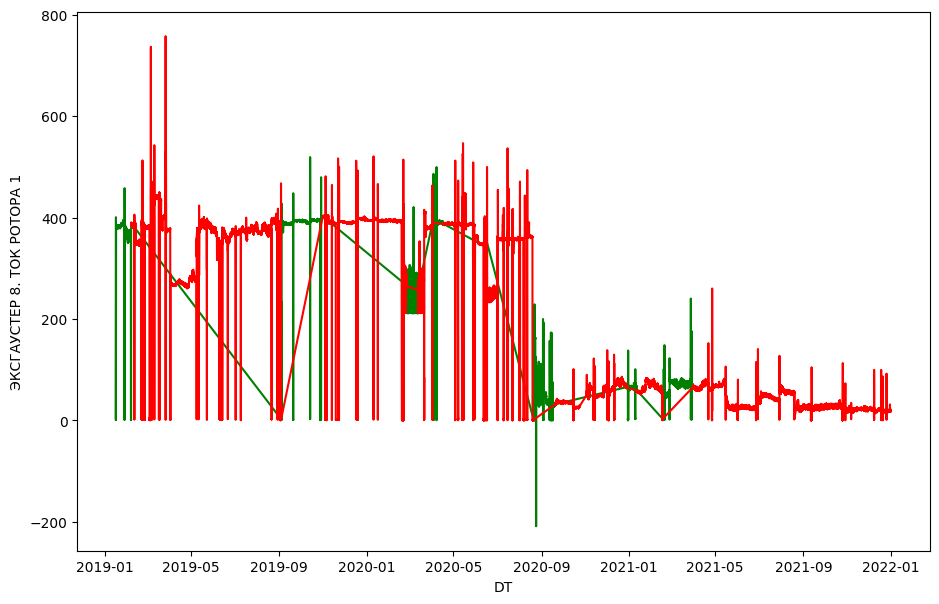

In [13]:
plot_failure(X[f'ЭКСГАУСТЕР {n}. ТОК РОТОРА 1'], y.iloc[:,0])

Оставляем начальный интервал X и y до первого сообщения о поломке, не имеющей даты устранения

In [15]:
endless_fail = endless_fail[endless_fail['НАЗВАНИЕ_ТЕХ_МЕСТА'].apply(lambda x: x in y_list)]

if len(endless_fail) == 0:
    print('Все неисправности M3 содержат дату устранения')
print(endless_fail.shape)
endless_fail
# Находим первое такое сообщение для нужного эксгаустера

(3, 10)


,Unnamed: 0,МАШИНА,ИМЯ_МАШИНЫ,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ВИД_СООБЩЕНИЯ,ОПИСАНИЕ,ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ,ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ,ТЕКСТ_ГРУППЫ_КОДОВ
557,1275,CH-AGP-AG2/009-005,ЭКСГАУСТЕР А/М №8,CH-AGP-AG2/009-005-001-008,КОЖУХ МУФТЫ ЭКСГ. №8,M3,утечка,2020-09-20 10:09:30,NaT,NaN
786,1817,CH-AGP-AG2/009-005,ЭКСГАУСТЕР А/М №8,CH-AGP-AG2/009-005-001-001,КОРПУС ЭКСГ. №8,M3,Просос по фланцу со стороны задвижки,2021-06-16 14:03:00,NaT,NaN
831,1906,CH-AGP-AG2/009-005,ЭКСГАУСТЕР А/М №8,CH-AGP-AG2/009-005-001-001,КОРПУС ЭКСГ. №8,M3,Прососы,2021-07-27 12:37:00,NaT,NaN


In [16]:
# Прибавляем M3_min = 8 минут к первому сообщению

if len(endless_fail) != 0:
    date = endless_fail['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'].iloc[0] + pd.Timedelta(minutes=8)
    print(date)
else:
    date = len(X)
del endless_fail

# Обрезаем выборку (если есть NaT)
X_train = X[:date]
y_train = y[:date]

2020-09-20 10:17:30


In [17]:
print(X_train.shape)
print(y_train.shape)

(5278618, 16)
(5278618, 3)


In [18]:
# Пропуски
X_train.isna().sum() / X_train.shape[0]

ЭКСГАУСТЕР 8. ТОК РОТОРА 1                         0.027792
ЭКСГАУСТЕР 8. ТОК РОТОРА 2                         0.033265
ЭКСГАУСТЕР 8. ТОК СТАТОРА                          0.026906
ЭКСГАУСТЕР 8. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ             0.030103
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1    0.036070
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2    0.029715
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3    0.035832
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4    0.034370
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ          0.025459
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ       0.032917
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 1                  0.029393
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 2                  0.065011
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3                  0.030025
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.     0.021452
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4                  0.064444
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.     0.028814
dtype: float64

In [19]:
# Необходимо удалить отрицательные значения в X

if (X_train < 0).any().any():
    X_train = X_train[(X_train >= 0)]
    y_train = y_train.loc[X_train.index]
    print("Отрицательные значения удалены")

Отрицательные значения удалены


In [20]:
# Интерполируем пропуски
X_train = X_train.interpolate()

In [21]:
# Корреляции начального участка
X_train.corrwith(y_train.iloc[:,1])

ЭКСГАУСТЕР 8. ТОК РОТОРА 1                         0.285737
ЭКСГАУСТЕР 8. ТОК РОТОРА 2                         0.285751
ЭКСГАУСТЕР 8. ТОК СТАТОРА                         -0.067534
ЭКСГАУСТЕР 8. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ             0.114637
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1    0.220988
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2    0.136387
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3    0.148207
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4    0.076687
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ          0.098032
ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ       0.276930
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 1                  0.402936
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 2                  0.408064
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3                  0.264739
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.     0.140614
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4                  0.209996
ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.     0.389980
dtype: float64

M0 (1112865,)
M1 (0,)
M3 (4165753,)


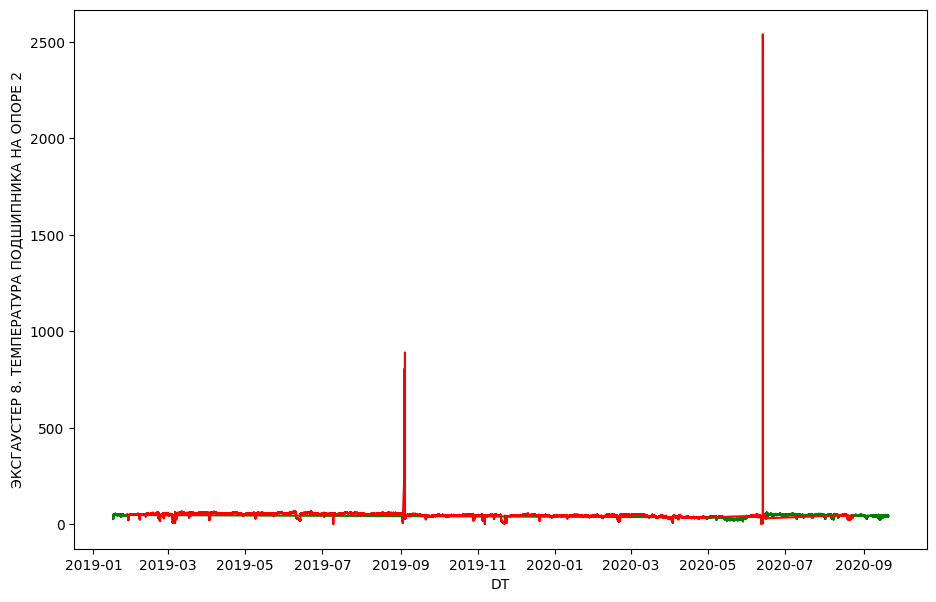

In [21]:
# График начального участка
plot_failure(X_train[f'ЭКСГАУСТЕР {n}. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2'], y_train.iloc[:,1])

M0 (1112865,)
M1 (0,)
M3 (4165753,)


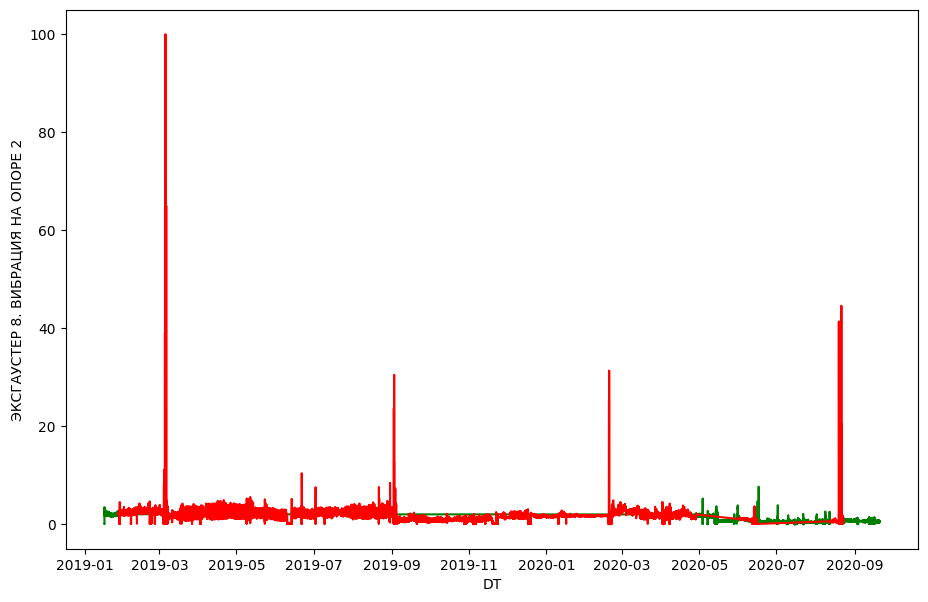

In [22]:
# График начального участка
plot_failure(X_train[f'ЭКСГАУСТЕР {n}. ВИБРАЦИЯ НА ОПОРЕ 2'], y_train.iloc[:,1])

In [22]:
y_train.replace(2, 1, inplace=True)
y_train.tail(2)

,Y_ЭКСГАУСТЕР А/М №8_КОРПУС ЭКСГ. №8,Y_ЭКСГАУСТЕР А/М №8_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8,Y_ЭКСГАУСТЕР А/М №8_КОЖУХ МУФТЫ ЭКСГ. №8
DT,,,
2020-09-20 10:17:20,1.0,0.0,1.0
2020-09-20 10:17:30,1.0,0.0,1.0


In [21]:
X_train.to_parquet('../../data/processed/ex8_M3_X_all_for_y_2,3,13.parquet')
y_train.to_parquet('../../data/processed/ex8_M3_y_2,3,13.parquet') # нумерация "y" начиная c №1 (по ошибке)

In [24]:
def plot_distribution(X, y):
    '''Распределение значений c авариями и без.'''
                
    # Разделяем индексы по поломкам в y
    M0_indx = y.loc[(y == 0).any(axis=1)].index   # без аварий
    M3_indx = y.loc[(y == 1).any(axis=1)].index   # авария без простоя
    # Разделяем Х по поломкам
    M0 = X.loc[M0_indx]
    M3 = X.loc[M3_indx]
    
    print('M0', M0.shape)
    print('M3', M3.shape)
        
    for col_m0, col_m1 in zip(M0.columns, M3.columns):
        df = pd.DataFrame({ 'M0': M0[col_m0].reset_index(drop=True), 'M3': M3[col_m1].reset_index(drop=True) })
        sns.boxplot(df)
        plt.ylabel(col_m0)
        plt.show()

    plt.close('all')

M0 (3807639, 16)
M3 (5184428, 16)


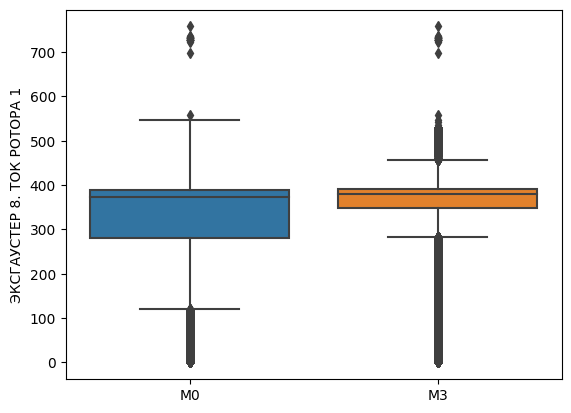

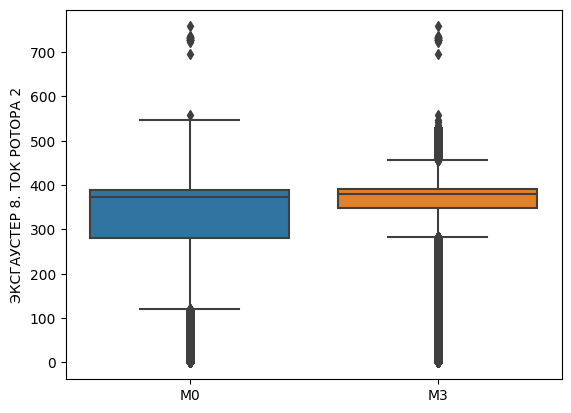

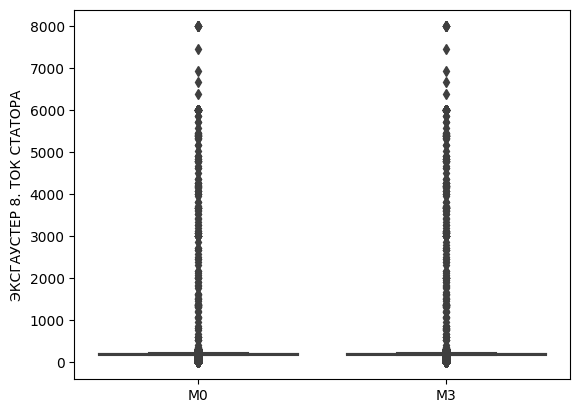

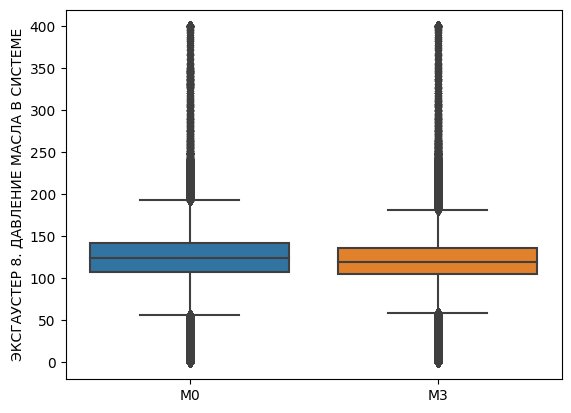

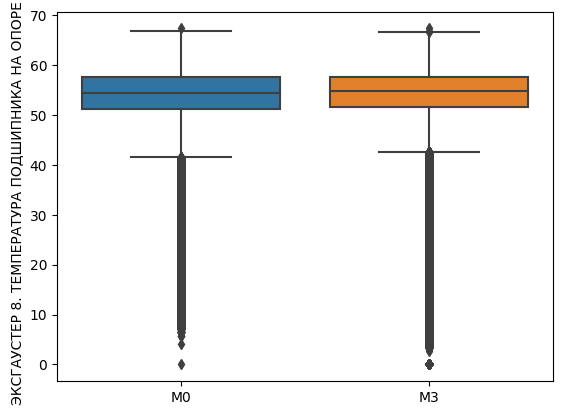

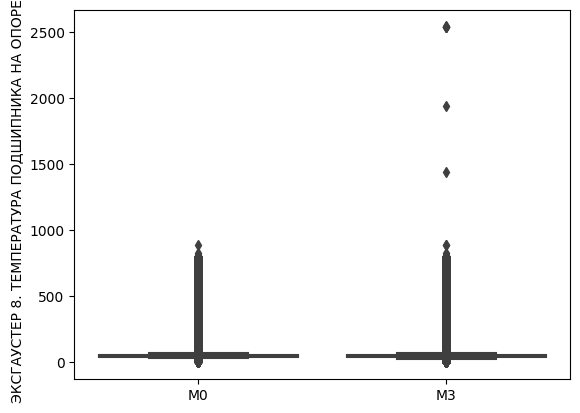

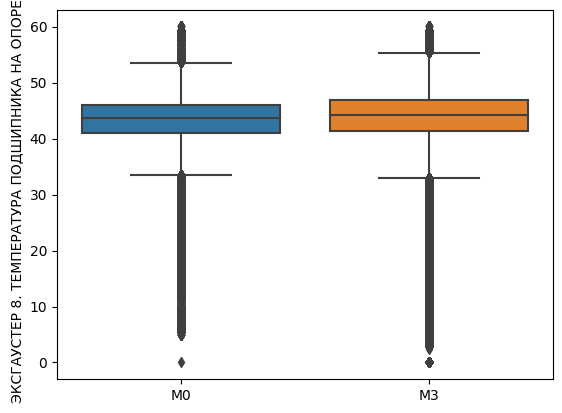

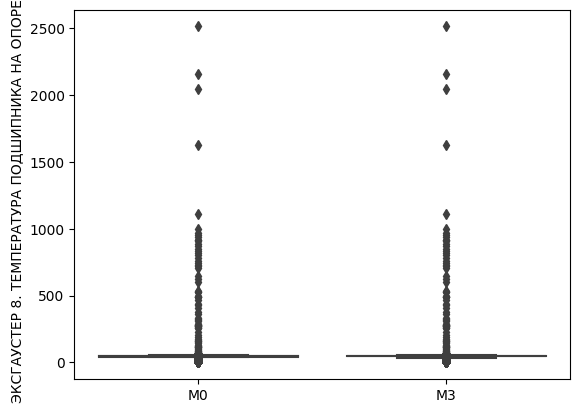

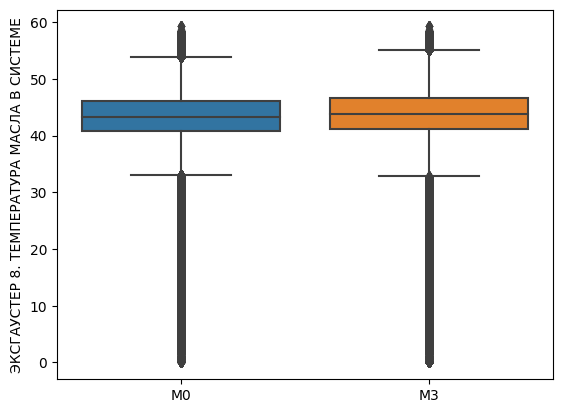

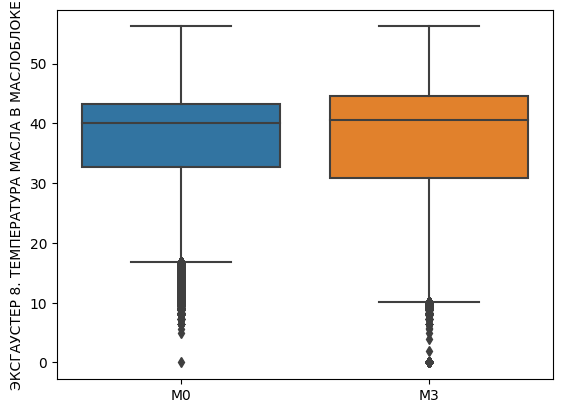

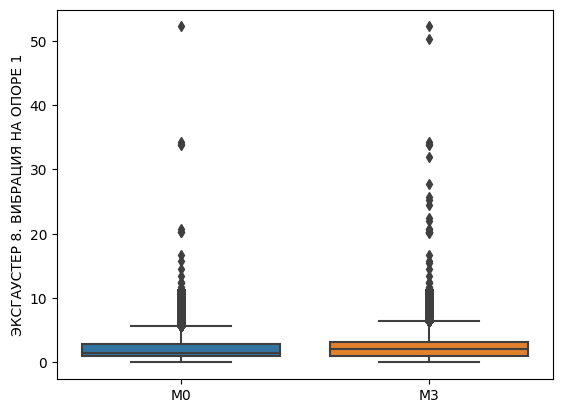

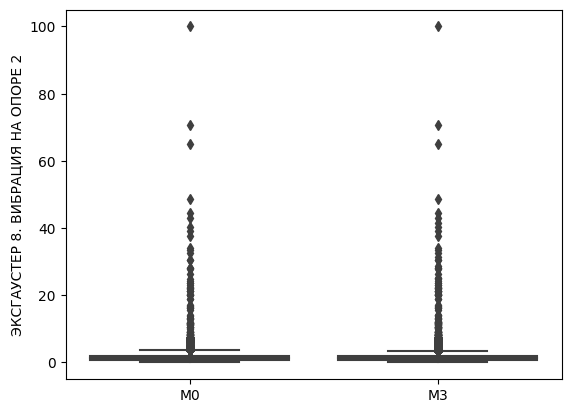

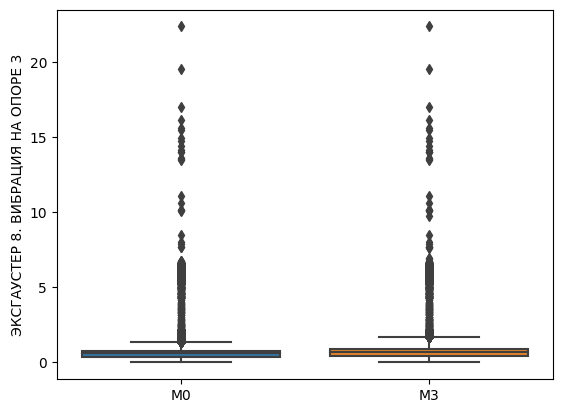

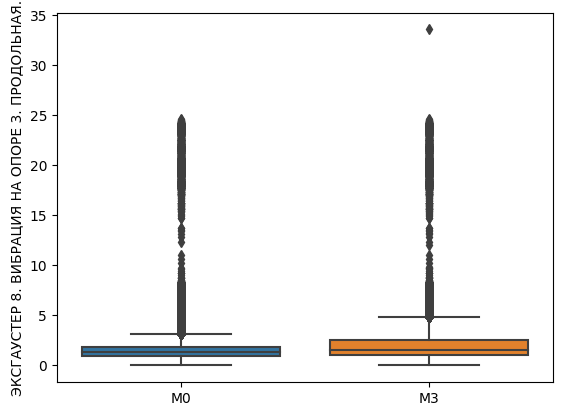

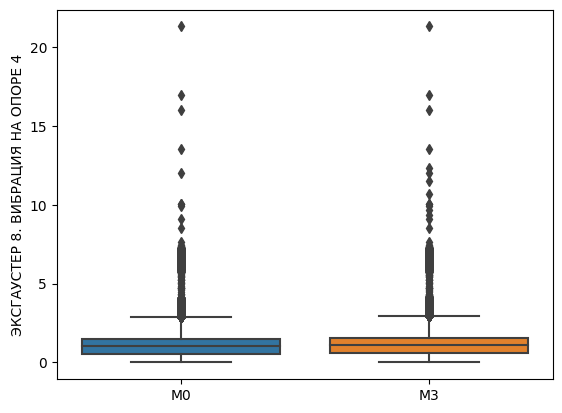

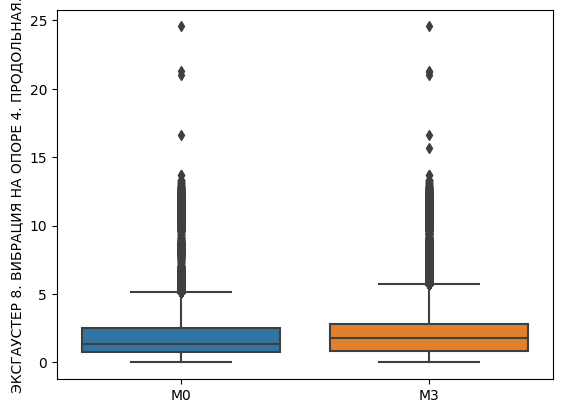

In [25]:
plot_distribution(X_train, y_train)